In [378]:
import pandas as pd
import math
import os
import string
import numpy as np
from sklearn import metrics
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.simplefilter('ignore')
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

import seaborn as sns
sns.set_style("whitegrid")

matplotlib.style.use('ggplot')
# use the code below to make sure plot is shown in Notebook
%matplotlib inline 

os.chdir('/Users/pawanshivhare/Desktop/Kaggle Competition/mckinsey_hack/data')

from subprocess import check_output
print(check_output(["ls", "../data"]).decode("utf8"))

explore1.csv
explore2.csv
final_predictions.csv
sample_submission_sLex1ul.csv
sne_test.csv
sne_train.csv
sub1.csv
sub2.csv
test_66516Ee.csv
train_ZoGVYWq.csv



In [379]:
dftrain=pd.read_csv('train_ZoGVYWq.csv')
dftest=pd.read_csv('test_66516Ee.csv')
print("Train obs: " + str(dftrain.shape[0]) + " ,Train Cols: " + str(dftrain.shape[1]))
print("Test obs: " + str(dftest.shape[0]) + " ,Test Cols: " + str(dftest.shape[1]))

Train obs: 79853 ,Train Cols: 13
Test obs: 34224 ,Test Cols: 12


In [380]:
def missing_data(data): #calculates missing values in each column
    total = data.isnull().sum().reset_index()
    total.columns  = ['Feature_Name','Missing_value']
    total_val = total[total['Missing_value']>0]
    total_val = total.sort_values(by ='Missing_value',ascending=[False])
    return total_val
missing_data(dftrain)

,Feature_Name,Missing_value
7,application_underwriting_score,2974
4,Count_3-6_months_late,97
5,Count_6-12_months_late,97
6,Count_more_than_12_months_late,97
0,id,0
1,perc_premium_paid_by_cash_credit,0
2,age_in_days,0
3,Income,0
8,no_of_premiums_paid,0
9,sourcing_channel,0


In [381]:
missing_data(dftest)

,Feature_Name,Missing_value
7,application_underwriting_score,1323
4,Count_3-6_months_late,31
5,Count_6-12_months_late,31
6,Count_more_than_12_months_late,31
0,id,0
1,perc_premium_paid_by_cash_credit,0
2,age_in_days,0
3,Income,0
8,no_of_premiums_paid,0
9,sourcing_channel,0


In [382]:
exclu=['id']
label=['renewal']
train_features=list(set(dftrain.columns.values.tolist()) - set(label)-set(exclu))

In [383]:
dftrain.head()

,id,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium,renewal
0,110936,0.429,12058,355060,0.0,0.0,0.0,99.02,13,C,Urban,3300,1
1,41492,0.010,21546,315150,0.0,0.0,0.0,99.89,21,A,Urban,18000,1
2,31300,0.917,17531,84140,2.0,3.0,1.0,98.69,7,C,Rural,3300,0
3,19415,0.049,15341,250510,0.0,0.0,0.0,99.57,9,A,Urban,9600,1
4,99379,0.052,31400,198680,0.0,0.0,0.0,99.87,12,B,Urban,9600,1


In [384]:
dftrain['renewal'].sum()/len(np.array(dftrain['renewal']))

#Wow 94% of customers have renewed the policy. Class Imbalance

0.937409990858202

In [385]:
dftrain['residence_area_type'].value_counts()/len(np.array(dftrain['residence_area_type']))

Urban    0.603396
Rural    0.396604
Name: residence_area_type, dtype: float64

In [386]:
dftest['residence_area_type'].value_counts()/len(np.array(dftest['residence_area_type']))

Urban    0.602151
Rural    0.397849
Name: residence_area_type, dtype: float64

In [387]:
dftrain['sourcing_channel'].value_counts()/len(np.array(dftrain['sourcing_channel']))

A    0.540168
B    0.206780
C    0.150765
D    0.094661
E    0.007627
Name: sourcing_channel, dtype: float64

In [388]:
dftest['sourcing_channel'].value_counts()/len(np.array(dftest['sourcing_channel']))

A    0.545582
B    0.202285
C    0.150362
D    0.094144
E    0.007626
Name: sourcing_channel, dtype: float64

In [389]:
dftrain[train_features].drop(['residence_area_type','sourcing_channel'],axis=1).describe()

,premium,perc_premium_paid_by_cash_credit,Count_more_than_12_months_late,no_of_premiums_paid,Count_6-12_months_late,application_underwriting_score,Income,age_in_days,Count_3-6_months_late
count,79853.000000,79853.000000,79756.000000,79853.000000,79756.000000,76879.000000,7.985300e+04,79853.000000,79756.000000
mean,10924.507533,0.314288,0.060008,10.863887,0.078188,99.067291,2.088472e+05,18846.696906,0.248671
std,9401.676542,0.334915,0.312023,5.170687,0.436507,0.739799,4.965826e+05,5208.719136,0.691468
min,1200.000000,0.000000,0.000000,2.000000,0.000000,91.900000,2.403000e+04,7670.000000,0.000000
25%,5400.000000,0.034000,0.000000,7.000000,0.000000,98.810000,1.080100e+05,14974.000000,0.000000
50%,7500.000000,0.167000,0.000000,10.000000,0.000000,99.210000,1.665600e+05,18625.000000,0.000000
75%,13800.000000,0.538000,0.000000,14.000000,0.000000,99.540000,2.520900e+05,22636.000000,0.000000
max,60000.000000,1.000000,11.000000,60.000000,17.000000,99.890000,9.026260e+07,37602.000000,13.000000


In [390]:
dftest[train_features].drop(['residence_area_type','sourcing_channel'],axis=1).describe()

,premium,perc_premium_paid_by_cash_credit,Count_more_than_12_months_late,no_of_premiums_paid,Count_6-12_months_late,application_underwriting_score,Income,age_in_days,Count_3-6_months_late
count,34224.000000,34224.000000,34193.000000,34224.000000,34193.000000,32901.000000,3.422400e+04,34224.000000,34193.000000
mean,10834.721248,0.314457,0.058111,10.890428,0.080718,99.061898,2.028201e+05,18824.215346,0.238733
std,9263.074506,0.334059,0.307046,5.216867,0.454634,0.742942,2.702536e+05,5246.525604,0.686162
min,1200.000000,0.000000,0.000000,2.000000,0.000000,91.900000,2.403000e+04,7671.000000,0.000000
25%,5400.000000,0.034000,0.000000,7.000000,0.000000,98.800000,1.063975e+05,14972.000000,0.000000
50%,7500.000000,0.169000,0.000000,10.000000,0.000000,99.210000,1.650700e+05,18623.000000,0.000000
75%,13800.000000,0.540000,0.000000,14.000000,0.000000,99.530000,2.500200e+05,22636.000000,0.000000
max,60000.000000,1.000000,7.000000,59.000000,10.000000,99.890000,2.191455e+07,35785.000000,12.000000


In [391]:
#distributions for train and test variables look similar

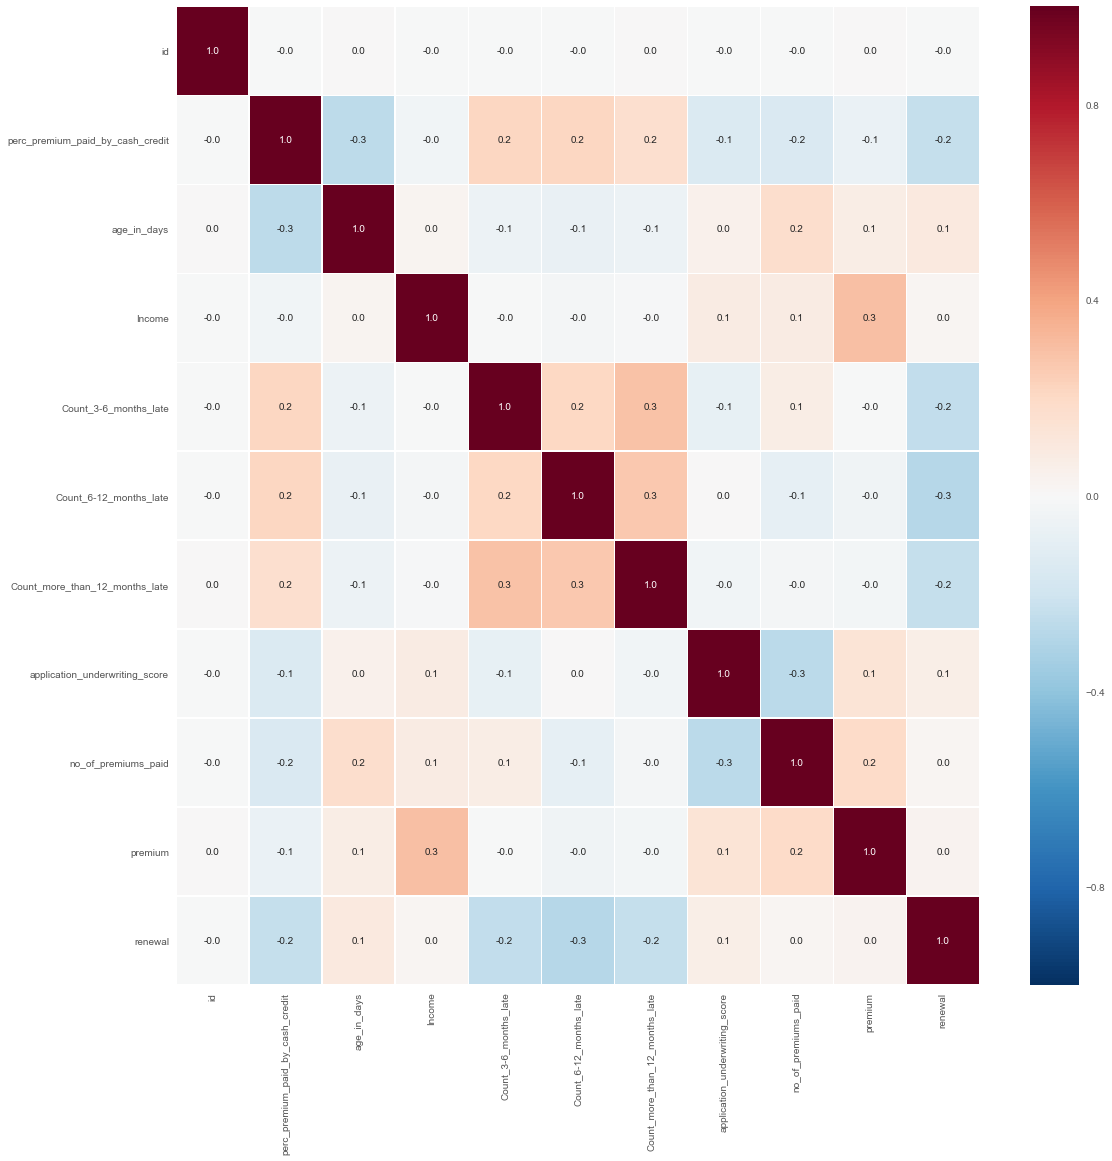

In [392]:
#Visualizations
corrset=dftrain._get_numeric_data().columns.values.tolist()
           
#correlation map
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(dftrain[corrset].corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

In [393]:
applt_nums=dftrain[train_features]._get_numeric_data().columns.values.tolist()
applt_vars=set(dftrain[train_features].columns.values.tolist())-set(dftrain[train_features]._get_numeric_data().columns.values.tolist())

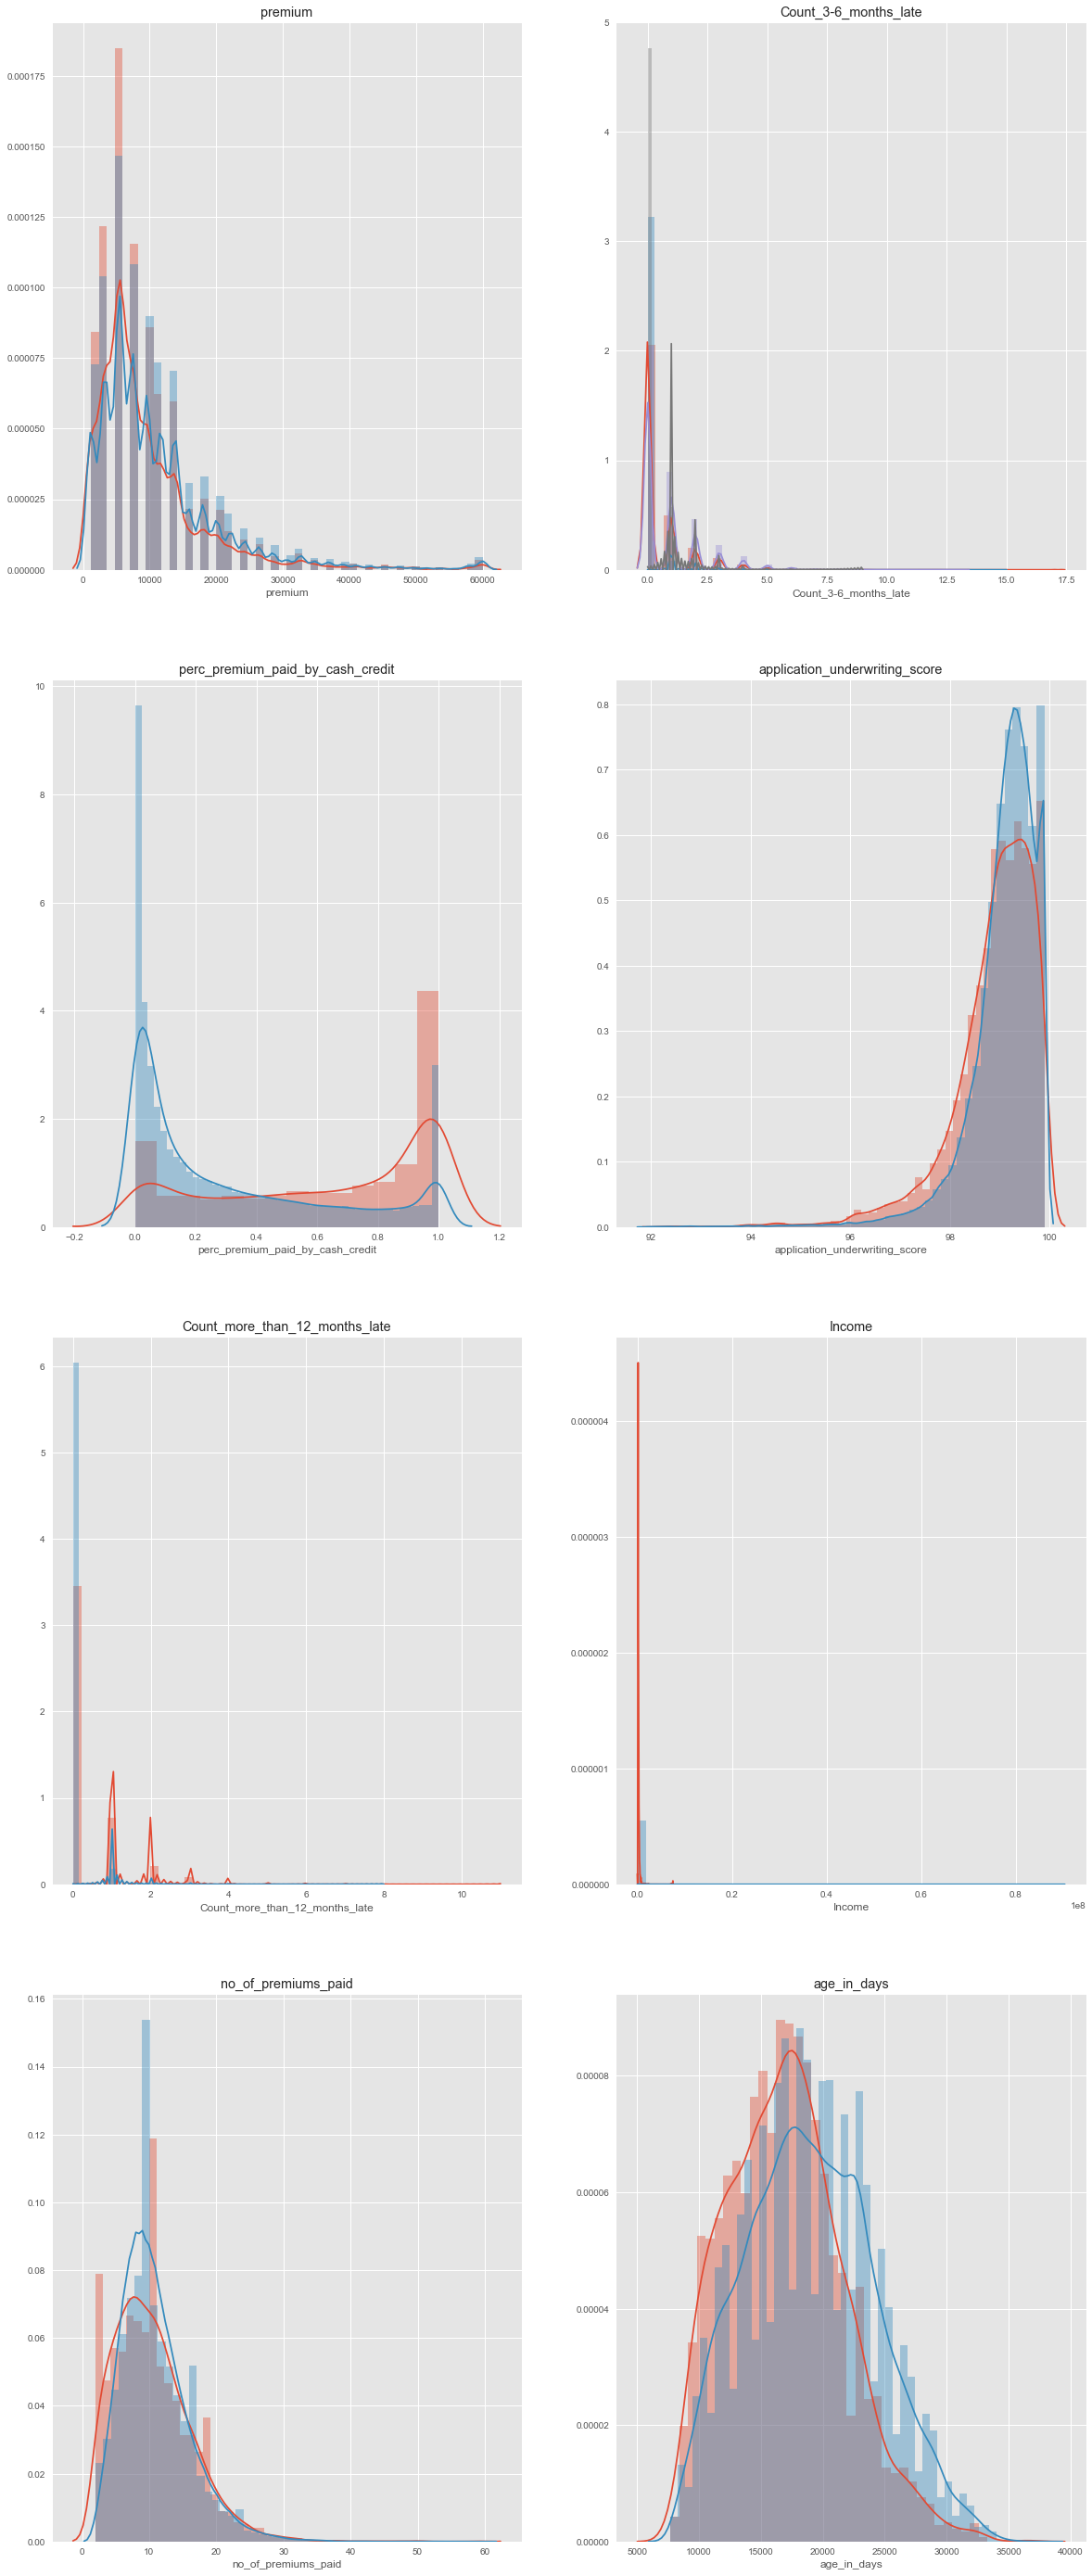

In [394]:
fig, axes = plt.subplots(nrows=round(len(applt_nums)/2), ncols=2,figsize=(20,50))
i=0
j=0
for item in applt_nums:
    sns.distplot(dftrain.loc[(dftrain['renewal']==0)][item].dropna(),ax=axes[i,j]); axes[i,j].set_title(item);
    sns.distplot(dftrain.loc[(dftrain['renewal']==1)][item].dropna(),ax=axes[i,j]); axes[i,j].set_title(item);
    if i == round(len(applt_nums)/2)-1: 
        i=0
        j=1
    else: i=i+1

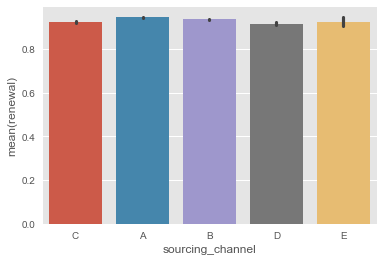

In [395]:
# Define a function for a bar plot

#sns.barplot(x="residence_area_type", y="renewal", data=dftrain, ci=68)
#sns.barplot(x="sourcing_channel", y="renewal", data=dftrain, ci=68)
sns.barplot(x='sourcing_channel',y='renewal', data=dftrain)


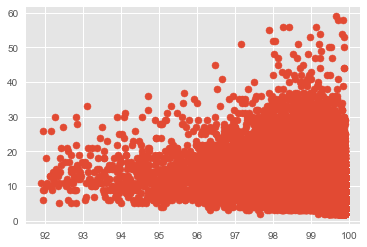

In [396]:
plt.scatter(dftrain['application_underwriting_score'],dftrain['no_of_premiums_paid'])

In [397]:
from sklearn.linear_model import LinearRegression

lr=LinearRegression()
lr.fit(dftrain.loc[dftrain['application_underwriting_score'].notnull()]['no_of_premiums_paid'].reshape(76879,1),
       dftrain.loc[dftrain['application_underwriting_score'].notnull()]['application_underwriting_score'].reshape(76879,1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [398]:
lr.coef_[0][0]
lr.intercept_[0]

99.500786468411164

In [399]:
#feature_engineering
dftrain['application_underwriting_score']=np.where(dftrain['application_underwriting_score'].isnull(),lr.intercept_[0]+lr.coef_[0][0]*dftrain['no_of_premiums_paid'],dftrain['application_underwriting_score'])
dftrain['missed_payments']=dftrain[[ 'Count_3-6_months_late','Count_6-12_months_late','Count_more_than_12_months_late']].sum(axis=1)
dftrain['l_age_in_days']=np.log(dftrain['age_in_days']+1)
dftrain['l_Income']=np.log(dftrain['Income']+1)
dftrain['l_application_underwriting_score']=np.log(dftrain['application_underwriting_score']+1)
dftrain['l_no_of_premiums_paid']=np.log(dftrain['no_of_premiums_paid']+1)
dftrain['l_perc_premium_paid_by_cash_credit']=np.log(dftrain['perc_premium_paid_by_cash_credit']+1)
dftrain['l_premium']=np.log(dftrain['premium']+1)
dftrain=dftrain.fillna(-99)
dftrain['l_missed_payments']=np.log(dftrain['missed_payments']+1)
dftrain=dftrain.fillna(-99)

dummies=pd.get_dummies(dftrain['residence_area_type'],prefix='ra')
#dftrain=pd.concat([dftrain,dummies],axis=1)

dummies=pd.get_dummies(dftrain['sourcing_channel'],prefix='channel')
#dftrain=pd.concat([dftrain,dummies],axis=1)


In [400]:
exclu=['id','sourcing_channel','residence_area_type','age_in_days','Income','application_underwriting_score',
      'no_of_premiums_paid','perc_premium_paid_by_cash_credit','premium','l_missed_payments'
      ]
label=['renewal']
train_features=list(set(dftrain.columns.values.tolist()) - set(label)-set(exclu))

In [25]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score 

skf = KFold(n_splits=5,shuffle=False, random_state=123)

skf.get_n_splits(np.array(dftrain[train_features]), np.array(dftrain[label]).flatten())

i=1
train_indices=dict()
test_indices=dict()
for train_index, test_index in skf.split(np.array(dftrain[train_features]), np.array(dftrain[label]).flatten()):    
    train_indices[i]=train_index
    test_indices[i]=test_index
    i=i+1

In [175]:
parameters = {'n_estimators':range(21,35),'max_depth':range(4,14)} # 33, 9

rf = RandomForestClassifier()

rfcv = GridSearchCV(rf, parameters,cv=5,scoring="roc_auc",n_jobs=5, return_train_score=False)
rfcv.fit(dftrain[train_features],np.array(dftrain[label]).flatten())

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=5,
       param_grid={'n_estimators': range(21, 35), 'max_depth': range(4, 14)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='roc_auc', verbose=0)

In [177]:
rfcv.best_params_

{'max_depth': 7, 'n_estimators': 33}

In [26]:
model1=RandomForestClassifier(n_estimators=33,max_depth=7)

result = cross_val_score(model1,dftrain[train_features], np.array(dftrain[label]).flatten(), cv=skf, scoring='roc_auc')

print("AUC:", result)
print("Mean AUC:", result.mean())
print("Median AUC:", np.median(result))

AUC: [ 0.83904511  0.83460217  0.83383504  0.84048552  0.83066106]
Mean AUC: 0.835725782175
Median AUC: 0.834602171965


In [27]:
rf = RandomForestClassifier(n_estimators=33,max_depth=9)
m=rf.fit(dftrain[train_features],np.array(dftrain[label]).flatten())

In [28]:
feat_imp=pd.concat([pd.DataFrame(train_features,columns=['feature']),
                    pd.DataFrame(m.feature_importances_,columns=['importance'])],axis=1)
feat_imp.sort_values("importance", inplace=True,ascending=False)
important_features=list(feat_imp[feat_imp['importance']>0]['feature'])

In [29]:
feat_imp

,feature,importance
0,l_missed_payments,0.470015
3,l_perc_premium_paid_by_cash_credit,0.217836
1,l_Income,0.108841
2,l_age_in_days,0.103118
4,l_application_underwriting_score,0.100191


In [30]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier
model2=MLPClassifier(hidden_layer_sizes=(5,),activation='logistic',solver='lbfgs',learning_rate='adaptive',alpha=0.0001)

result = cross_val_score(model2,scale(dftrain[train_features]), np.array(dftrain[label]).flatten(), cv=skf, scoring='roc_auc')

print("AUC:", result)
print("Mean AUC:", result.mean())
print("Median AUC:", np.median(result))

AUC: [ 0.83757194  0.83517324  0.83294663  0.84137404  0.82991384]
Mean AUC: 0.835395939533
Median AUC: 0.83517323708


In [376]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dftrain[train_features], dftrain[label]
                                                    , test_size=0.3, random_state=123)
s_train=scale(X_train)
s_test=scale(X_test)

In [401]:
import lightgbm as lgb

def lgb_run(X_train,y_train, val_X, val_y):
    params = {}
    params['learning_rate'] = 0.004
    params['boosting_type'] = 'gbdt'
    params['objective'] = 'binary'
    params['metric'] = 'auc'
    params['num_leaves'] = 25
    params['max_depth'] = -1
    params['feature_fraction'] = 0.5
    params['bagging_fraction'] = 0.5
    params['verbosity'] = -1
    params['random_seed']= 42
    params['bagging_seed']= 42
    params['bagging_frequency'] =5
    #params['num_iteration']=1065
    
    lgtrain = lgb.Dataset(X_train, label=y_train)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 5000,
                      valid_sets=[lgtrain,lgval], 
                      early_stopping_rounds=100, 
                      verbose_eval=100, 
                      evals_result=evals_result)
    
    #pred_test_y = np.expm1(model.predict(test_X, num_iteration=model.best_iteration))
    return  model, evals_result

model7, evals_result7 = lgb_run(X_train, np.array(y_train).flatten(), X_test, np.array(y_test).flatten())
print("LightGBM Training Completed...")


Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.848771	valid_1's auc: 0.836151
[200]	training's auc: 0.85145	valid_1's auc: 0.837671
[300]	training's auc: 0.85428	valid_1's auc: 0.838421
[400]	training's auc: 0.856414	valid_1's auc: 0.838834
[500]	training's auc: 0.85829	valid_1's auc: 0.83963
[600]	training's auc: 0.860442	valid_1's auc: 0.840066
[700]	training's auc: 0.862362	valid_1's auc: 0.840327
[800]	training's auc: 0.864745	valid_1's auc: 0.840465
[900]	training's auc: 0.867179	valid_1's auc: 0.8405
[1000]	training's auc: 0.869659	valid_1's auc: 0.840448
Early stopping, best iteration is:
[940]	training's auc: 0.868215	valid_1's auc: 0.840553
LightGBM Training Completed...


In [404]:
dftest['renewal']=model7.predict(dftest[train_features])

In [34]:
import xgboost as xgb

### load data in do training
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
params = {
    # Parameters that we are going to tune.
    'max_depth':3,
    'min_child_weight': 6,
    'eta':0.1,
    'subsample': 0.7,
    'colsample_bytree': 0.9,
    'silent': 1,
    # Other parameters
    'objective':'binary:logistic',
}
params['eval_metric'] = "auc"
num_boost_round = 999

model8 = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10,
    verbose_eval=20
)

print("Best RMSE: {:.2f} with {} rounds".format(
                 model8.best_score,
                 model8.best_iteration+1))

[0]	Test-auc:0.802691
Will train until Test-auc hasn't improved in 10 rounds.
[20]	Test-auc:0.826987
[40]	Test-auc:0.830345
[60]	Test-auc:0.831426
[80]	Test-auc:0.831928
Stopping. Best iteration:
[88]	Test-auc:0.832174

Best RMSE: 0.83 with 89 rounds


In [35]:
from sklearn.linear_model import RidgeClassifier

parameters = {'alpha':[0.1,0.05,0.01,0.0000001,0]}

ridge = RidgeClassifier()

ridgecv = GridSearchCV(ridge, parameters,cv=5,scoring="roc_auc",n_jobs=5, return_train_score=False)
ridgecv.fit(dftrain[train_features],np.array(dftrain[label]).flatten())
print(ridgecv.best_params_)
print(ridgecv.best_score_)

{'alpha': 1e-07}
0.828897719658


In [36]:
model3=RidgeClassifier(alpha=0)
result = cross_val_score(model3,dftrain[train_features], np.array(dftrain[label]).flatten(), cv=skf, scoring='roc_auc')

print("AUC:", result)
print("Mean AUC:", result.mean())
print("Median AUC:", np.median(result))

AUC: [ 0.83177185  0.82835135  0.82672747  0.8350445   0.82248392]
Mean AUC: 0.828875818006
Median AUC: 0.828351349488


In [37]:
from sklearn.linear_model import LogisticRegression

parameters = {'C':[0.05,0.01,0.02]}
lgr=LogisticRegression(penalty='l2')
lgrcv = GridSearchCV(lgr, parameters,cv=5,scoring="roc_auc",n_jobs=5, return_train_score=False)
lgrcv.fit(dftrain[train_features],np.array(dftrain[label]).flatten())
print(lgrcv.best_params_)
print(lgrcv.best_score_)

{'C': 0.05}
0.829600594842


In [38]:
model4=LogisticRegression(penalty='l2',C=0.01)
result = cross_val_score(model4,dftrain[train_features], np.array(dftrain[label]).flatten(), cv=skf, scoring='roc_auc')

print("AUC:", result)
print("Mean AUC:", result.mean())
print("Median AUC:", np.median(result))

AUC: [ 0.83166226  0.82831243  0.82675647  0.83487155  0.82130164]
Mean AUC: 0.828580869413
Median AUC: 0.828312434594


In [74]:
from sklearn.neighbors import KNeighborsClassifier

parameters = {'n_neighbors':range(169,200)} #best 6

knn=KNeighborsClassifier()

knn = GridSearchCV(knn, parameters,cv=3,scoring='roc_auc',n_jobs=5, return_train_score=False)
knn.fit(scale(X_train), np.array(y_train).flatten())

GridSearchCV(cv=3, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=5,
       param_grid={'n_neighbors': range(169, 200)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='roc_auc', verbose=0)

In [77]:
knn.best_params_

{'n_neighbors': 190}

In [79]:
model5=KNeighborsClassifier(n_neighbors=190)

result = cross_val_score(model5,scale(dftrain[train_features]), np.array(dftrain[label]).flatten(), cv=skf, scoring='roc_auc')

print("AUC:", result)
print("Mean AUC:", result.mean())
print("Median AUC:", np.median(result))

AUC: [ 0.83331259  0.83378367  0.82666393  0.83211006  0.82316912]
Mean AUC: 0.829807874179
Median AUC: 0.832110057472


In [80]:
model9=KNeighborsClassifier(n_neighbors=250)

result = cross_val_score(model9,scale(dftrain[train_features]), np.array(dftrain[label]).flatten(), cv=skf, scoring='roc_auc')

print("AUC:", result)
print("Mean AUC:", result.mean())
print("Median AUC:", np.median(result))

AUC: [ 0.83506179  0.83341286  0.82815291  0.83500147  0.82543333]
Mean AUC: 0.831412470466
Median AUC: 0.833412855075


In [81]:
model10=KNeighborsClassifier(n_neighbors=350)

result = cross_val_score(model10,scale(dftrain[train_features]), np.array(dftrain[label]).flatten(), cv=skf, scoring='roc_auc')

print("AUC:", result)
print("Mean AUC:", result.mean())
print("Median AUC:", np.median(result))

AUC: [ 0.83633493  0.83449498  0.83135992  0.83648472  0.8258835 ]
Mean AUC: 0.832911612494
Median AUC: 0.834494983676


In [83]:
model11=KNeighborsClassifier(n_neighbors=500)

result = cross_val_score(model11,scale(dftrain[train_features]), np.array(dftrain[label]).flatten(), cv=skf, scoring='roc_auc')

print("AUC:", result)
print("Mean AUC:", result.mean())
print("Median AUC:", np.median(result))

AUC: [ 0.83704781  0.8331965   0.83251787  0.83549979  0.82700655]
Mean AUC: 0.833053702865
Median AUC: 0.833196504553


In [84]:
model12=KNeighborsClassifier(n_neighbors=750)

result = cross_val_score(model12,scale(dftrain[train_features]), np.array(dftrain[label]).flatten(), cv=skf, scoring='roc_auc')

print("AUC:", result)
print("Mean AUC:", result.mean())
print("Median AUC:", np.median(result))

AUC: [ 0.8377186   0.83296258  0.83367466  0.83683964  0.82573795]
Mean AUC: 0.833386682015
Median AUC: 0.833674655122


In [85]:
model13=KNeighborsClassifier(n_neighbors=1000)

result = cross_val_score(model13,scale(dftrain[train_features]), np.array(dftrain[label]).flatten(), cv=skf, scoring='roc_auc')

print("AUC:", result)
print("Mean AUC:", result.mean())
print("Median AUC:", np.median(result))

AUC: [ 0.83788136  0.83383111  0.83215476  0.83716135  0.8268186 ]
Mean AUC: 0.833569438633
Median AUC: 0.833831111863


In [86]:
model14=KNeighborsClassifier(n_neighbors=1500)

result = cross_val_score(model14,scale(dftrain[train_features]), np.array(dftrain[label]).flatten(), cv=skf, scoring='roc_auc')

print("AUC:", result)
print("Mean AUC:", result.mean())
print("Median AUC:", np.median(result))

AUC: [ 0.83729095  0.83354918  0.83126393  0.83798356  0.82792944]
Mean AUC: 0.833603411817
Median AUC: 0.833549182537


In [87]:
model15=KNeighborsClassifier(n_neighbors=2000)

result = cross_val_score(model15,scale(dftrain[train_features]), np.array(dftrain[label]).flatten(), cv=skf, scoring='roc_auc')

print("AUC:", result)
print("Mean AUC:", result.mean())
print("Median AUC:", np.median(result))

AUC: [ 0.83725065  0.83303978  0.83052729  0.83855696  0.82841902]
Mean AUC: 0.833558739666
Median AUC: 0.83303977967


In [99]:
from sklearn.cluster import KMeans

kmeans=KMeans(n_clusters=5).fit(dftrain[train_features])
k_train=kmeans.predict(dftrain[train_features])
#k_test=kmeans.predict(dftest[train_features])
pd.Series(k_train).value_counts()

2    24822
4    23350
3    12248
0    10187
1     9246
dtype: int64

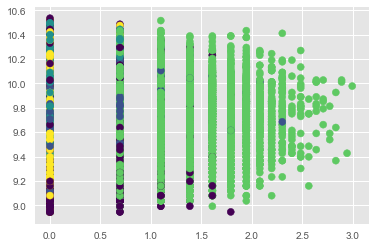

In [100]:
plt.scatter(dftrain['l_missed_payments'],dftrain['l_age_in_days'], c=k_train, cmap='viridis',label=k_train)

In [101]:
X_train1=np.array(dftrain[train_features])[train_indices[1]]
X_train2=np.array(dftrain[train_features])[train_indices[2]]
X_train3=np.array(dftrain[train_features])[train_indices[3]]
X_train4=np.array(dftrain[train_features])[train_indices[4]]
X_train5=np.array(dftrain[train_features])[train_indices[5]]


y_train1=np.array(dftrain[label])[train_indices[1]]
y_train2=np.array(dftrain[label])[train_indices[2]]
y_train3=np.array(dftrain[label])[train_indices[3]]
y_train4=np.array(dftrain[label])[train_indices[4]]
y_train5=np.array(dftrain[label])[train_indices[5]]

X_test1=np.array(dftrain[train_features])[test_indices[1]]
X_test2=np.array(dftrain[train_features])[test_indices[2]]
X_test3=np.array(dftrain[train_features])[test_indices[3]]
X_test4=np.array(dftrain[train_features])[test_indices[4]]
X_test5=np.array(dftrain[train_features])[test_indices[5]]


y_test1=np.array(dftrain[label])[test_indices[1]]
y_test2=np.array(dftrain[label])[test_indices[2]]
y_test3=np.array(dftrain[label])[test_indices[3]]
y_test4=np.array(dftrain[label])[test_indices[4]]
y_test5=np.array(dftrain[label])[test_indices[5]]

In [121]:
def lgb_run1(X_train,y_train):
    params = {}
    params['learning_rate'] = 0.004
    params['boosting_type'] = 'gbdt'
    params['objective'] = 'binary'
    params['metric'] = 'auc'
    params['num_leaves'] = 25
    params['max_depth'] = -1
    params['feature_fraction'] = 0.5
    params['bagging_fraction'] = 0.5
    params['verbosity'] = -1
    params['random_seed']= 42
    params['bagging_seed']= 42
    params['bagging_frequency'] =5
    params['num_iteration']=757
    
    lgtrain = lgb.Dataset(X_train, label=y_train)
    model = lgb.train(params, lgtrain)
    return  model

In [171]:
names=train_features + ['renewal','r1','r2','r3','r4','r5','r6','r7','r8','r9','r10','r11','r12','r13']

In [151]:
def score(dftr,labtr,dfte,labte):
    
    
    model1= lgb_run1(dftr, np.array(labtr).flatten()) #Score: 1.44
    print("LightGBM Training Completed...")
    
    dtrain = xgb.DMatrix(dftr, label=labtr)
    params = {
    # Parameters that we are going to tune.
    'max_depth':3,
    'min_child_weight': 6,
    'eta':0.1,
    'subsample': 0.7,
    'colsample_bytree': 0.9,
    'silent': 1,
    # Other parameters
    'objective':'binary:logistic',
    'eval_metric':'auc'
    }
    model2 = xgb.train(params,dtrain,num_boost_round=89)
    model3=RandomForestClassifier(n_estimators=33,max_depth=7)
    model3.fit(dftr,np.array(labtr).flatten())
    model4=MLPClassifier(hidden_layer_sizes=(5,),activation='logistic',solver='lbfgs',learning_rate='adaptive',alpha=0.0001)
    model4.fit(scale(dftr),np.array(labtr).flatten())
    model5=LogisticRegression(penalty='l2',C=0.01)
    model5.fit(dftr,np.array(labtr).flatten())
    model6=KNeighborsClassifier(n_neighbors=190)
    model6.fit(scale(dftr),np.array(labtr).flatten())
    model7=KNeighborsClassifier(n_neighbors=250)
    model7.fit(scale(dftr),np.array(labtr).flatten())
    model8=KNeighborsClassifier(n_neighbors=350)
    model8.fit(scale(dftr),np.array(labtr).flatten())
    model9=KNeighborsClassifier(n_neighbors=500)
    model9.fit(scale(dftr),np.array(labtr).flatten())
    model10=KNeighborsClassifier(n_neighbors=750)
    model10.fit(scale(dftr),np.array(labtr).flatten())
    model11=KNeighborsClassifier(n_neighbors=1000)
    model11.fit(scale(dftr),np.array(labtr).flatten())
    model12=KNeighborsClassifier(n_neighbors=1500)
    model12.fit(scale(dftr),np.array(labtr).flatten())
    model13=KNeighborsClassifier(n_neighbors=2000)
    model13.fit(scale(dftr),np.array(labtr).flatten())
    
    dftarget=pd.DataFrame(labte.flatten(),columns=['renewal'])
    dftarget['r1']=model1.predict(dfte)
    dftarget['r2']=model2.predict(xgb.DMatrix(dfte, label=None))
    dftarget['r3']=model3.predict_proba(dfte)[:,1]
    dftarget['r4']=model4.predict_proba(scale(dfte))[:,1]
    dftarget['r5']=model5.predict_proba(dfte)[:,1]
    dftarget['r6']=model6.predict_proba(scale(dfte))[:,1]
    dftarget['r7']=model7.predict_proba(scale(dfte))[:,1]
    dftarget['r8']=model8.predict_proba(scale(dfte))[:,1]
    dftarget['r9']=model9.predict_proba(scale(dfte))[:,1]
    dftarget['r10']=model10.predict_proba(scale(dfte))[:,1]
    dftarget['r11']=model11.predict_proba(scale(dfte))[:,1]
    dftarget['r12']=model12.predict_proba(scale(dfte))[:,1]
    dftarget['r13']=model13.predict_proba(scale(dfte))[:,1]
    
    final_set=pd.concat([pd.DataFrame(dfte,columns=train_features),dftarget],axis=1)
    return dftarget,final_set  

In [152]:
targets1, testset1= score(X_train1,y_train1,X_test1,y_test1)

LightGBM Training Completed...


In [154]:
targets2, testset2= score(X_train2,y_train2,X_test2,y_test2)
targets3, testset3= score(X_train3,y_train3,X_test3,y_test3)
targets4, testset4= score(X_train4,y_train4,X_test4,y_test4)
targets5, testset5= score(X_train5,y_train5,X_test5,y_test5)

targets=pd.concat([targets1,targets2,targets3,targets4,targets5]).reset_index(drop=True)
final_trainset=pd.concat([testset1,testset2,testset3,testset4,testset5]).reset_index(drop=True)

LightGBM Training Completed...
LightGBM Training Completed...
LightGBM Training Completed...
LightGBM Training Completed...


In [156]:
kmeans=KMeans(n_clusters=5).fit(final_trainset[train_features])
k_train=kmeans.predict(final_trainset[train_features])
#k_test=kmeans.predict(dftest[train_features])
pd.Series(k_train).value_counts()

0    24742
3    21856
4    12322
2    11483
1     9450
dtype: int64

In [157]:
final_trainset['cluster']=k_train

In [158]:
sne_train=pd.read_csv('sne_train.csv')
sne_test=pd.read_csv('sne_test.csv')

In [165]:
final_trainset['sne1']=sne_train['0']
final_trainset['sne2']=sne_train['1']

In [257]:
exclu=['l_missed_payments','l_Income','l_age_in_days','l_perc_premium_paid_by_cash_credit',
    'l_application_underwriting_score']
label=['renewal']
main_features=list(set(final_trainset.columns.values.tolist()) - set(label)-set(exclu))

In [258]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score 

skf1 = StratifiedKFold(n_splits=3,shuffle=False, random_state=567)
skf1.get_n_splits(np.array(final_trainset[main_features]), np.array(final_trainset[label]).flatten())

3

In [210]:
parameters = {'hidden_layer_sizes':[(3,)],'activation':['logistic'],
'solver' : ['lbfgs'],'alpha':[4]}

mlp2=MLPClassifier(learning_rate='adaptive',alpha=0.0001)
mlpcv = GridSearchCV(mlp2, parameters,cv=5,scoring="roc_auc",n_jobs=5, return_train_score=False)
mlpcv.fit(scale(final_trainset[main_features]),np.array(final_trainset[label]).flatten())

GridSearchCV(cv=5, error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params=None, iid=True, n_jobs=5,
       param_grid={'hidden_layer_sizes': [(3,)], 'activation': ['logistic'], 'solver': ['lbfgs'], 'alpha': [4, 5, 6, 7, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='roc_auc', verbose=0)

In [259]:
modell21=MLPClassifier(learning_rate='adaptive',alpha=4,hidden_layer_sizes=(3,),activation='logistic',solver='lbfgs')
#modell21.fit(scale(final_trainset[main_features],np.array(final_trainset[label]).flatten())


result = cross_val_score(modell21,scale(final_trainset[main_features]), np.array(final_trainset[label]).flatten(), cv=skf1, scoring='roc_auc')

print("AUC:", result)
print("Mean AUC:", result.mean())
print("Median AUC:", np.median(result))

AUC: [ 0.83600852  0.83844434  0.83576064]
Mean AUC: 0.836737832174
Median AUC: 0.836008521716


In [220]:
X_train, X_test, y_train, y_test = train_test_split(final_trainset[main_features], final_trainset[label]
                                                    , test_size=0.4, random_state=123)


In [261]:
modell21=MLPClassifier(learning_rate='adaptive',alpha=4,hidden_layer_sizes=(3,),activation='logistic',solver='lbfgs')
modell21.fit(scale(final_trainset[main_features]),np.array(final_trainset[label]).flatten())

MLPClassifier(activation='logistic', alpha=4, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(3,), learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [250]:
parameters = {'n_estimators':range(15,22),'max_depth':range(3,6)} # 33, 9

rf = RandomForestClassifier()

rfcv = GridSearchCV(rf, parameters,cv=5,scoring="roc_auc",n_jobs=5, return_train_score=False)
rfcv.fit(final_trainset[main_features], np.array(final_trainset[label]).flatten())

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=5,
       param_grid={'n_estimators': range(15, 22), 'max_depth': range(3, 6)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='roc_auc', verbose=0)

In [262]:
rfcv.best_params_

{'max_depth': 4, 'n_estimators': 18}

In [263]:
modell22=RandomForestClassifier(n_estimators=18,max_depth=4)

result = cross_val_score(modell22,final_trainset[main_features], np.array(final_trainset[label]).flatten(), cv=skf1, scoring='roc_auc')

print("AUC:", result)
print("Mean AUC:", result.mean())
print("Median AUC:", np.median(result))

AUC: [ 0.83626119  0.83767263  0.83546165]
Mean AUC: 0.836465155789
Median AUC: 0.836261191716


In [267]:
import lightgbm as lgb

def lgb_run(X_train,y_train, val_X, val_y):
    params = {}
    params['learning_rate'] = 0.005
    params['boosting_type'] = 'dart'
    params['objective'] = 'binary'
    params['metric'] = 'auc'
    params['num_leaves'] = 6
    params['max_depth'] = -1
    params['feature_fraction'] = 0.5
    params['bagging_fraction'] = 0.5
    params['verbosity'] = -1
    params['random_seed']= 42
    params['bagging_seed']= 42
    params['bagging_frequency'] =5
    #params['num_iteration']=1065
    

    
    lgtrain = lgb.Dataset(X_train, label=y_train)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 5000,
                      valid_sets=[lgtrain,lgval], 
                      early_stopping_rounds=100, 
                      verbose_eval=100, 
                      evals_result=evals_result)
    
    #pred_test_y = np.expm1(model.predict(test_X, num_iteration=model.best_iteration))
    return  model, evals_result

modell22, evals_resultl22 = lgb_run(X_train, np.array(y_train).flatten(), X_test, np.array(y_test).flatten())
print("LightGBM Training Completed...")


Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.854995	valid_1's auc: 0.832035
Early stopping, best iteration is:
[71]	training's auc: 0.854652	valid_1's auc: 0.832116
LightGBM Training Completed...


In [284]:
import xgboost as xgb

### load data in do training
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
params = {
    # Parameters that we are going to tune.
    'max_depth':2,
    'min_child_weight': 7,
    'eta':0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.9,
    'silent': 1,
    # Other parameters
    'objective':'binary:logistic',
}
params['eval_metric'] = "auc"
num_boost_round = 999

model8 = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtrain, "Train"),(dtest, "Test")],
    early_stopping_rounds=10,
    verbose_eval=20
)

print("Best RMSE: {:.2f} with {} rounds".format(
                 model8.best_score,
                 model8.best_iteration+1))

[0]	Train-auc:0.798882	Test-auc:0.789525
Multiple eval metrics have been passed: 'Test-auc' will be used for early stopping.

Will train until Test-auc hasn't improved in 10 rounds.
[20]	Train-auc:0.838789	Test-auc:0.83004
[40]	Train-auc:0.843006	Test-auc:0.832788
Stopping. Best iteration:
[43]	Train-auc:0.843205	Test-auc:0.83287

Best RMSE: 0.83 with 44 rounds


In [403]:
#feature_engineering
dftest['application_underwriting_score']=np.where(dftest['application_underwriting_score'].isnull(),lr.intercept_[0]+lr.coef_[0][0]*dftest['no_of_premiums_paid'],dftest['application_underwriting_score'])
dftest['missed_payments']=dftest[[ 'Count_3-6_months_late','Count_6-12_months_late','Count_more_than_12_months_late']].sum(axis=1)
dftest['l_age_in_days']=np.log(dftest['age_in_days']+1)
dftest['l_Income']=np.log(dftest['Income']+1)
dftest['l_application_underwriting_score']=np.log(dftest['application_underwriting_score']+1)
dftest['l_no_of_premiums_paid']=np.log(dftest['no_of_premiums_paid']+1)
dftest['l_perc_premium_paid_by_cash_credit']=np.log(dftest['perc_premium_paid_by_cash_credit']+1)
dftest['l_premium']=np.log(dftest['premium']+1)
dftest=dftest.fillna(-99)
dftest['l_missed_payments']=np.log(dftest['missed_payments']+1)
dftest=dftest.fillna(-99)

dummies=pd.get_dummies(dftest['residence_area_type'],prefix='ra')
#dftest=pd.concat([dftest,dummies],axis=1)

dummies=pd.get_dummies(dftest['sourcing_channel'],prefix='channel')
#dftest=pd.concat([dftest,dummies],axis=1)


In [292]:
def score1(dftr,labtr,dfte,l):
    
    temp=dfte[l]
    
    model1= lgb_run1(dftr, np.array(labtr).flatten()) #Score: 1.44
    print("LightGBM Training Completed...")
    
    dtrain = xgb.DMatrix(dftr, label=labtr)
    params = {
    # Parameters that we are going to tune.
    'max_depth':3,
    'min_child_weight': 6,
    'eta':0.1,
    'subsample': 0.7,
    'colsample_bytree': 0.9,
    'silent': 1,
    # Other parameters
    'objective':'binary:logistic',
    'eval_metric':'auc'
    }
    model2 = xgb.train(params,dtrain,num_boost_round=89)
    model3=RandomForestClassifier(n_estimators=33,max_depth=7)
    model3.fit(dftr,np.array(labtr).flatten())
    model4=MLPClassifier(hidden_layer_sizes=(5,),activation='logistic',solver='lbfgs',learning_rate='adaptive',alpha=0.0001)
    model4.fit(scale(dftr),np.array(labtr).flatten())
    model5=LogisticRegression(penalty='l2',C=0.01)
    model5.fit(dftr,np.array(labtr).flatten())
    model6=KNeighborsClassifier(n_neighbors=190)
    model6.fit(scale(dftr),np.array(labtr).flatten())
    model7=KNeighborsClassifier(n_neighbors=250)
    model7.fit(scale(dftr),np.array(labtr).flatten())
    model8=KNeighborsClassifier(n_neighbors=350)
    model8.fit(scale(dftr),np.array(labtr).flatten())
    model9=KNeighborsClassifier(n_neighbors=500)
    model9.fit(scale(dftr),np.array(labtr).flatten())
    model10=KNeighborsClassifier(n_neighbors=750)
    model10.fit(scale(dftr),np.array(labtr).flatten())
    model11=KNeighborsClassifier(n_neighbors=1000)
    model11.fit(scale(dftr),np.array(labtr).flatten())
    model12=KNeighborsClassifier(n_neighbors=1500)
    model12.fit(scale(dftr),np.array(labtr).flatten())
    model13=KNeighborsClassifier(n_neighbors=2000)
    model13.fit(scale(dftr),np.array(labtr).flatten())
    
    dfte['r1']=model1.predict(temp)
    dfte['r2']=model2.predict(xgb.DMatrix(temp, label=None))
    dfte['r3']=model3.predict_proba(temp)[:,1]
    dfte['r4']=model4.predict_proba(scale(temp))[:,1]
    dfte['r5']=model5.predict_proba(temp)[:,1]
    dfte['r6']=model6.predict_proba(scale(temp))[:,1]
    dfte['r7']=model7.predict_proba(scale(temp))[:,1]
    dfte['r8']=model8.predict_proba(scale(temp))[:,1]
    dfte['r9']=model9.predict_proba(scale(temp))[:,1]
    dfte['r10']=model10.predict_proba(scale(temp))[:,1]
    dfte['r11']=model11.predict_proba(scale(temp))[:,1]
    dfte['r12']=model12.predict_proba(scale(temp))[:,1]
    dfte['r13']=model13.predict_proba(scale(temp))[:,1]
    
    return dfte 

In [293]:
final_testset=score1(dftrain[train_features],np.array(dftrain[label]).flatten(),dftest,train_features)

LightGBM Training Completed...


In [295]:
final_testset['cluster']=kmeans.predict(final_testset[train_features])
final_testset['sne1']=sne_test['0']
final_testset['sne2']=sne_test['1']

In [305]:
modell21=MLPClassifier(learning_rate='adaptive',alpha=4,hidden_layer_sizes=(3,),activation='logistic',solver='lbfgs')
modell21.fit(scale(final_trainset[main_features]),np.array(final_trainset[label]).flatten())

modell22=RandomForestClassifier(n_estimators=18,max_depth=4)
modell22.fit(final_trainset[main_features],np.array(final_trainset[label]).flatten())

params = {}
params['learning_rate'] = 0.005
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'auc'
params['num_leaves'] = 8
params['max_depth'] = -1
params['feature_fraction'] = 0.8
params['bagging_fraction'] = 0.9
params['verbosity'] = -1
params['random_seed']= 42
params['bagging_seed']= 42
params['bagging_frequency'] =5
params['num_iteration']=350
   
lgtrain = lgb.Dataset(final_trainset[main_features], label=np.array(final_trainset[label]).flatten())
modell23 = lgb.train(params, lgtrain)

dtrain = xgb.DMatrix(final_trainset[main_features], label=np.array(final_trainset[label]).flatten())
params = {
# Parameters that we are going to tune.
'max_depth':2,
'min_child_weight': 7,
'eta':0.1,
'subsample': 0.8,
'colsample_bytree': 0.9,
'silent': 1,
# Other parameters
'objective':'binary:logistic',
'eval_metric':'auc'
}
modell24 = xgb.train(params,dtrain,num_boost_round=43)

In [306]:
final_testset['l2_r1']=modell21.predict_proba(scale(final_testset[main_features]))[:,1]
final_testset['l2_r2']=modell22.predict_proba(final_testset[main_features])[:,1]
final_testset['l2_r3']=modell23.predict(final_testset[main_features])
final_testset['l2_r4']=modell24.predict(xgb.DMatrix(final_testset[main_features],label=None))

In [413]:
final_testset.to_csv('final_predictions.csv',index=False)

In [412]:
final_testset['renewal']=0.55*final_testset['l2_r4']+0.45*final_testset['l2_r1']